## Notebook for Solar Wind Exploration

In the initial phase, we want to see if we can detect FTEs using unsupervised learning, by finding a manifold for the solar wind data.

The initial hypothesis is the transition matrices (Markov Matrices $M$) that can be derived from Manifolder + clustering will show distinctive clusters and transitions.  We can check accuracy by looking at the label (FTE or not?), and see if this label could have been deduced from the data itself.



In [1]:
# useful set of python includes

%load_ext autoreload
%autoreload 2

import numpy as np

np.set_printoptions(suppress=True, precision=4)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

# import seaborn as sns
# sns.set()

import pandas as pd

import time

import random

import os

### Load Solar Wind Data, and Run Manifolder

The `dataset_2` file contains 

Dataset-2 (THEMIS):   a list with FTEs periods and non-FTEs periods observed by THEMIS in 2007.  These are combined into one file, randomly FTE - NonFTE - FTE - FTE, NonFTE, etc…

In total there are 63 FTEs and 47 non-FTEs.

The time series are separated by one blank line, and each one has 1440 points in a period of 6 minutes.


In [2]:
os.getcwd()

'C:\\Users\\Trey\\Documents\\GitHub\\manifolder\\code\\astro'

In [3]:
import sys
# sys.path.append(r"C:\Users\acloninger\GDrive\ac2528Backup\DocsFolder\GitHub\manifolder")
sys.path.append(r"..")

#sys.path.append("/home/jovyan/gen-mod-vol/avlab/manifolder/code")

import manifolder as mr
from manifolder import helper as mh


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [4]:
# load the data
# note, you must have started the notebook in the 
print('loading data ...')
df = pd.read_excel('astro_data/dataset_2.xlsx', index_col=0)
df.head()


loading data ...


<ipython-input-4-9c392a75d805>:4: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  df = pd.read_excel('astro_data/dataset_2.xlsx', index_col=0)


,bx\t,by\t,bz\t,bl\t,bm\t,bn\t,bmag\t,vx\t,vy\t,vz\t,vmag\t,np,Unnamed: 13,tpar,tper,tp,goal
sc time,,,,,,,,,,,,,,,,,
thd,1.177999e+09,2.06,-4.87,17.77,17.80,4.55,-2.48,18.54,-5.96,2.42,6.94,9.46,0.11,3938.25,3565.04,3689.44,1.0
thd,1.177999e+09,2.01,-4.89,17.69,17.72,4.53,-2.53,18.47,-7.04,1.11,6.79,9.85,0.11,3924.28,3610.40,3715.03,1.0
thd,1.177999e+09,2.01,-4.87,17.71,17.74,4.51,-2.52,18.48,-8.14,-0.21,6.66,10.52,0.11,3910.35,3656.06,3740.82,1.0
thd,1.177999e+09,2.02,-4.80,17.74,17.77,4.47,-2.45,18.48,-9.23,-1.53,6.52,11.40,0.11,3896.40,3701.56,3766.51,1.0
thd,1.177999e+09,1.99,-4.83,17.70,17.73,4.47,-2.50,18.45,-10.26,-2.82,6.37,12.40,0.11,3882.37,3746.46,3791.77,1.0


In [5]:
# convert values from loaded spreadsheet, into a numpy matrices
# note that there is no need for the first value, which is time,
# as it is not part of the manifold
#
# also, note the spreadsheet is missing a column name for `Unnamed: 13`, and the values above
# this have the incorrect column labels; the first relevant vale is bx, which as a magnitude around 2
#
# note the final value of each row is the goal (0 or 1), and not part of z

data_raw = df.values[:, 1:]
print('first line of raw_data:\n', data_raw[0, :])


first line of raw_data:
 [   2.06   -4.87   17.77   17.8     4.55   -2.48   18.54   -5.96    2.42
    6.94    9.46    0.11 3938.25 3565.04 3689.44    1.  ]


In [6]:
import pickle
#Load Data
segments = np.load('themis/segments-newdata-all.npy')

# Load Labels
labels = np.load('themis/labels-newdata-all.npy')
labels = np.asarray(pd.get_dummies(labels))

#Load Bounding Boxes/ Event Locations
with open('themis/bbox.pickle','rb') as f:
    bboxes = pickle.load(f)

In [7]:
# loop through the data, breaking out the clusters
# i will always point to the NaN (blank line) in the dataframe,
# and values [i-1440:i] is the snipped

snippet_len = 1440

# collect all line breaks (blank lines) in csv file
#lineBreaks = [0]
#for i in range(data_raw.shape[0]):
#    if data_raw[i,0] != data_raw[i,0]:  # replacement of isnan, since nan != nan
#        lineBreaks.append(i)    
#lineBreaks.append(data_raw.shape[0])
#
#num_snippet = len(lineBreaks)-1


# callect the snippets into two groups, one for each goal (target) value, 0 or 1
# these can be easily merged
zs_0 = []
zs_1 = []

locallabel_0 = []
locallabel_1 = []
snippet_index = 0;

df.values[0,:]

reduce_dimension = True

for i in range(snippet_len,data_raw.shape[0]+1,snippet_len+1):
    # copy the snipped, excluding the last value, which is the goal
    snippet = data_raw[i-snippet_len:i,:-1]
    
    if reduce_dimension:
        snippet = snippet[:,5]
        snippet = snippet.reshape(snippet_len,1)

    # grab the goal value from the first row of each snippet
    goal = data_raw[i-snippet_len,-1]
    
    # check to make sure each snippet does not contain NaN
    # (should not, if parsing is correct)
    assert ~np.isnan(snippet).any(), 'oops, snippet contains a Nan!'
    
    print('snippet size',snippet.shape,'with goal',goal)
    
    snippetlabel = np.zeros(snippet_len)
    if goal == 1:
        bmin = int(bboxes[snippet_index][0][0])
        bmax = int(bboxes[snippet_index][0][2])
        snippetlabel[bmin:bmax] = 1
    
    if goal == 0:
        zs_0.append( snippet )
        locallabel_0.append( snippetlabel )
    elif goal == 1:
        zs_1.append( snippet )
        locallabel_1.append( snippetlabel )
    else:
        assert False, 'value of goal not understood'
        
    snippet_index = snippet_index + 1;
        

# shuffle this lists; this should not strictly be necessary, if all the data is being used,
# but prevents biases when shortening the list

c0 = list(zip(zs_0, locallabel_0))
random.shuffle(c0)
zs_0, locallabel_0 = zip(*c0)
zs_0 = list(zs_0)
locallabel_0 = list(locallabel_0)

c1 = list(zip(zs_1, locallabel_1))
random.shuffle(c1)
zs_1, locallabel_1 = zip(*c1)
zs_1 = list(zs_1)
locallabel_1 = list(locallabel_1)

shorten_data = False

if shorten_data:
    zs_0 = zs_0[:20]
    zs_1 = zs_1[:20]
    locallabel_0 = locallabel_0[:20]
    locallabel_1 = locallabel_1[:20]
        
zs = zs_0 + zs_1
locallabel = locallabel_0 + locallabel_1
z_breakpoint = len(zs_0)

print( '\done!')
print( '\t len(zs_0):',len(zs_0))
print( '\t len(zs_1):',len(zs_1))
print( '\t len(zs):',len(zs))


snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
s

In [8]:
len(locallabel)

104

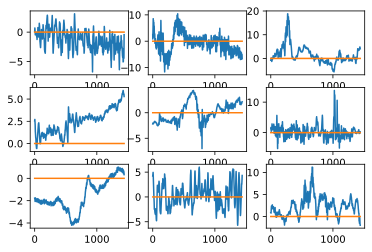

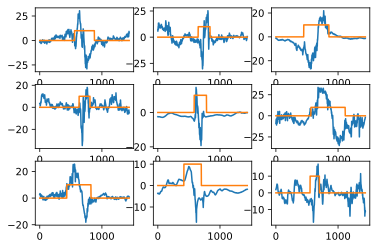

In [9]:
# import matplotlib.pyplot as plt

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(zs_0[i][:,5])
    else:
        plt.plot(zs_0[i][:,0])
        
    plt.plot(10*locallabel_0[i])
    
plt.show()

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(zs_1[i][:,5])
    else:
        plt.plot(zs_1[i][:,0])
    plt.plot(10*locallabel_1[i])

    
plt.show()



dim=6
H = 160
step_size = 20
nbins = 10
ncov = 10

In [10]:
# data has been parsed, now run Manifolder


start_time = time.time()

# create manifolder object
manifolder = mr.Manifolder(dim=dim,H=H,step_size=step_size,nbins=nbins, ncov=ncov)

# add the data, and fit (this runs all the functions)
#manifolder.fit_transform(zs, parallel=False, dtw="raw")
manifolder.fit_transform(zs, parallel=True)

elapsed_time = time.time() - start_time
print('\n\t Program Executed in', str(np.round(elapsed_time, 2)), 'seconds')  # about 215 seconds (four minutes)


Calculating histograms in parallel ... done in  4.41 seconds!
Computing local covariances in parallel ... done in  1.17 seconds!
using 4000 for variable m
computing Dis matrix in parallel
Python version is >= 3.8, using shared memory
done in  2.63 seconds!
aniostropic kernel ... Using partial symmetric eigensolver from scipy
done
extending embedding (building Psi) ... done

	 Program Executed in 15.93 seconds


In [11]:
snippet_psi = []
size = manifolder.Psi.shape[0] // len(zs)
for i in range(0, manifolder.Psi.shape[0], size):
    snippet_psi.append(manifolder.Psi[i:i+size, :])

import dcor
dcor_dm = np.zeros((len(zs), len(zs)))
start_time = time.time()
for i in range(len(snippet_psi)):
    for j in range(i):
        distance = dcor.homogeneity.energy_test_statistic(snippet_psi[i], snippet_psi[j])
        dcor_dm[i,j] = distance
        dcor_dm[j,i] = distance
print('\n\t Dcor Executed in', str(np.round(time.time() - start_time, 2)), 'seconds')
print(dcor_dm)


	 Dcor Executed in 1.07 seconds
[[0.     0.54   0.4305 ... 0.5193 0.2508 0.7066]
 [0.54   0.     0.4172 ... 0.5611 0.5566 0.3048]
 [0.4305 0.4172 0.     ... 0.2268 0.5572 0.5095]
 ...
 [0.5193 0.5611 0.2268 ... 0.     0.718  0.5529]
 [0.2508 0.5566 0.5572 ... 0.718  0.     0.9175]
 [0.7066 0.3048 0.5095 ... 0.5529 0.9175 0.    ]]


In [12]:
locallabel_downsample = np.empty(0, float)
for i in range(len(locallabel)):
    x = locallabel[i]
    x = x[0:x.shape[0]-H]
    x = x[::step_size]

    locallabel_downsample = np.append(locallabel_downsample,x,0)
    
Psi = manifolder.Psi[:,0:manifolder.Dim]
    
print(locallabel_downsample.shape)
print(Psi.shape)

(6656,)
(6656, 6)


In [13]:
snippet_psi = []
size = manifolder.Psi.shape[0] // len(zs)
for i in range(0, manifolder.Psi.shape[0], size):
    snippet_psi.append(manifolder.Psi[i:i+size, :])

print(size)
print(manifolder.Psi.shape[0])

64
6656


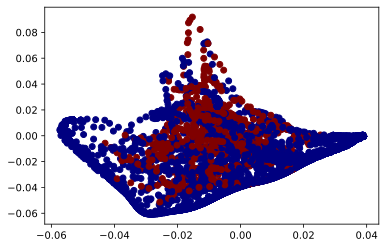

In [14]:
plt.scatter(manifolder.Psi[:,0],manifolder.Psi[:,2],c=locallabel_downsample,cmap='jet')

from sklearn.cluster import KMeans
singledim = []
for snippet in zs:
    singledim.append(snippet[:,0])

results = []
for i in range(10000):
    kmeans_orig = KMeans(n_clusters=2).fit(singledim)
    found = False
    for temp in results:
        if (kmeans_orig.labels_ == temp[0]).all() or (kmeans_orig.labels_ != temp[0]).all():
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeans_orig.labels_, 1])
results = sorted(results, key=lambda array: array[1])
print(results)
cluster_out = results[-1][0]
print(cluster_out)
truePositive = 0
falsePositive = 0
trueNegative = 0
falseNegative=0
for i in range(len(zs_0)):
    if cluster_out[i] == 0:
        trueNegative += 1
    else:
        falsePositive += 1
for i in range(len(zs_0), len(zs)):
    if cluster_out[i] == 1:
        truePositive += 1
    else:
        falseNegative += 1
print("TN:", trueNegative)
print("FP:", falsePositive)
print("TP:", truePositive)
print("FN:", falseNegative)

In [15]:
# this will read the dtw matrix from the file
import pickle
try:
    f = open("dtw_distmat_snippets_dim_5.pickle", 'rb')
    dtw_distmat_dim_5 = pickle.load(f)
finally:
    f.close()

print(dtw_distmat_dim_5.shape)

(104, 104)


In [27]:
from pyclustering.cluster.kmedoids import kmedoids
#from sklearn_extra.cluster import KMedoids
#from sklearn.utils import check_random_state

def try_medoids(nclust, dm):
    len_data = dm.shape[0]
    initial_medoids = random.sample(range(len_data), nclust)
    #initial_medoids = KMedoids(n_clusters=nclust, init='heuristic', max_iter=0, metric='precomputed')._initialize_medoids(dm, nclust, check_random_state(None))
    #initial_medoids = KMedoids(n_clusters=nclust, init='k-medoids++', max_iter=0, metric='precomputed')._initialize_medoids(dm, nclust, check_random_state(None))
    #initial_medoids = KMedoids(n_clusters=nclust, init='build', max_iter=0, metric='precomputed')._initialize_medoids(dm, nclust, check_random_state(None))
    kmedoids_instance = kmedoids(dm, initial_medoids, data_type = 'distance_matrix')
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    #print(clusters)
    clusters[0].sort()
    clusters[1].sort()
    return clusters

In [28]:
def print_results(results, max_printed=1):
    for i in range(min(len(results), max_printed)):
        cluster_out = results[len(results)-1-i][0]
        print(cluster_out)
        truePositive = 0
        falsePositive = 0
        trueNegative = 0
        falseNegative=0
        for i in range(len(cluster_out[0])):
            if cluster_out[0][i] < len(zs_0):
                trueNegative += 1
            else:
                falsePositive += 1
        for i in range(len(cluster_out[1])):
            if cluster_out[1][i] >= len(zs_0):
                truePositive += 1
            else:
                falseNegative += 1
        print("TN:", trueNegative)
        print("FP:", falsePositive)
        print("TP:", truePositive)
        print("FN:", falseNegative)

In [29]:
# clustering results from dtw

results = []
for i in range(10000):
    kmeds = try_medoids(2, dtw_distmat_dim_5)
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1]))or \
        (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])

print("########################################################################")
print("before sorting")
print(results)
print("after sorting")
results = sorted(results, key=lambda array: array[1])
print(results)
print("########################################################################")


print_results(results)

########################################################################
before sorting
[[[[1, 4, 5, 7, 8, 11, 12, 13, 17, 19, 21, 23, 24, 27, 28, 29, 33, 36, 37, 38, 40, 42, 43, 44, 51, 55, 56, 58, 63, 65, 66, 72, 76, 78, 80, 84, 86, 90, 91, 92, 94, 96, 98, 99, 103], [0, 2, 3, 6, 9, 10, 14, 15, 16, 18, 20, 22, 25, 26, 30, 31, 32, 34, 35, 39, 41, 45, 46, 47, 48, 49, 50, 52, 53, 54, 57, 59, 60, 61, 62, 64, 67, 68, 69, 70, 71, 73, 74, 75, 77, 79, 81, 82, 83, 85, 87, 88, 89, 93, 95, 97, 100, 101, 102]], 3828], [[[0, 2, 6, 9, 10, 14, 15, 16, 18, 20, 22, 25, 26, 30, 31, 32, 34, 35, 39, 41, 45, 46, 47, 48, 49, 50, 53, 54, 57, 59, 60, 61, 62, 64, 67, 68, 70, 71, 73, 74, 75, 81, 83, 85, 87, 88, 93, 95, 97, 100, 101], [1, 3, 4, 5, 7, 8, 11, 12, 13, 17, 19, 21, 23, 24, 27, 28, 29, 33, 36, 37, 38, 40, 42, 43, 44, 51, 52, 55, 56, 58, 63, 65, 66, 69, 72, 76, 77, 78, 79, 80, 82, 84, 86, 89, 90, 91, 92, 94, 96, 98, 99, 102, 103]], 772], [[[2, 10, 14, 15, 16, 22, 25, 30, 31, 34, 35, 45, 46, 48, 49, 54

In [19]:
# clustering results from manifolder with energy distance

results = []
for i in range(10000):
    kmeds = try_medoids(2, dcor_dm)
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1]))or \
        (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])
        
print("########################################################################")
print("before sorting")
print(results)
print("after sorting")
results = sorted(results, key=lambda array: array[1])
print(results)
print("########################################################################")

print_results(results)

########################################################################
before sorting
[[[[1, 2, 3, 4, 5, 8, 9, 13, 14, 16, 17, 18, 19, 22, 23, 24, 25, 27, 31, 34, 38, 40, 43, 44, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103], [0, 6, 7, 10, 11, 12, 15, 20, 21, 26, 28, 29, 30, 32, 33, 35, 36, 37, 39, 41, 42, 45, 51, 62, 76, 102]], 232], [[[0, 1, 2, 4, 5, 7, 8, 14, 16, 17, 18, 19, 20, 21, 22, 23, 28, 29, 31, 33, 34, 35, 37, 40, 42, 44, 46, 57, 72, 76, 86, 92, 96, 102], [3, 6, 9, 10, 11, 12, 13, 15, 24, 25, 26, 27, 30, 32, 36, 38, 39, 41, 43, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 93, 94, 95, 97, 98, 99, 100, 101, 103]], 179], [[[1, 2, 3, 4, 5, 7, 8, 14, 16, 18, 19, 23, 31, 34, 37, 40, 44, 5

In [20]:
snippet_windows = []

for snip in range(len(zs)):
    z = zs[snip]
    i_range = int(np.floor(z.shape[0] - H) / step_size)
    window = np.zeros((H, i_range))
    #print(window.shape)
    for i in range(i_range):
        # interval = z(dim, 1 + (i - 1) * stepSize: (i - 1) * stepSize + H);
        interval = z[i * step_size:i * step_size + H, 0]
        #print(interval.shape)
        window[:, i] = interval
    snippet_windows.append(window)

print(snippet_windows)

import dcor
dcor_dm_nm = np.zeros((len(zs), len(zs)))
start_time = time.time()
for i in range(len(snippet_windows)):
    for j in range(i):
        distance = dcor.homogeneity.energy_test_statistic(snippet_windows[i], snippet_windows[j])
        dcor_dm_nm[i,j] = distance
        dcor_dm_nm[j,i] = distance
print('\n\t Dcor Executed in', str(np.round(time.time() - start_time, 2)), 'seconds')
print(dcor_dm_nm)

[array([[ 0.11, -0.3 , -0.81, ..., -1.64, -3.46, -1.46],
       [ 0.21, -0.17, -0.69, ..., -1.93, -2.59, -1.72],
       [ 0.56, -0.04, -0.65, ..., -2.1 , -1.5 , -1.86],
       ...,
       [-2.42, -1.1 ,  2.23, ..., -2.86, -1.66, -4.24],
       [-2.77, -0.79,  2.28, ..., -2.52, -1.44, -3.78],
       [-3.04, -0.2 ,  2.34, ..., -2.09, -1.4 , -3.36]]), array([[ 2.52,  4.09,  0.02, ...,  1.46, -3.82, -5.99],
       [ 0.84,  3.8 , -0.33, ..., -0.21, -3.81, -5.18],
       [ 1.8 ,  4.38, -0.24, ..., -2.03, -3.8 , -4.55],
       ...,
       [-4.67, -7.86, -6.16, ..., -5.29, -2.53, -5.89],
       [-3.19, -7.37, -4.71, ..., -5.38, -3.58, -6.07],
       [-1.47, -5.88, -5.04, ..., -5.43, -5.09, -6.22]]), array([[-0.8 , -0.93,  1.15, ...,  0.75,  0.72, -0.71],
       [-0.67, -0.7 ,  0.91, ...,  0.83,  0.46, -0.53],
       [-0.53, -0.64,  0.83, ...,  0.78,  0.46, -0.48],
       ...,
       [ 2.29,  3.94,  4.81, ...,  0.4 ,  3.05,  3.93],
       [ 2.75,  4.59,  6.09, ...,  0.04,  4.01,  3.58],
       


	 Dcor Executed in 16.08 seconds
[[   0.     1511.6227 2546.0783 ... 1344.5566  734.9877 1564.4187]
 [1511.6227    0.     3187.4472 ... 1251.3993 1598.4497 1437.943 ]
 [2546.0783 3187.4472    0.     ... 1253.532  3113.2659 2001.2916]
 ...
 [1344.5566 1251.3993 1253.532  ...    0.     1653.0266 1194.9206]
 [ 734.9877 1598.4497 3113.2659 ... 1653.0266    0.     1310.9867]
 [1564.4187 1437.943  2001.2916 ... 1194.9206 1310.9867    0.    ]]


In [25]:

results = []
for i in range(10000):
    kmeds = try_medoids(2, dcor_dm_nm)
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1])) or \
        (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])


print("########################################################################")
print("before sorting")
print(results)
print("after sorting")
results = sorted(results, key=lambda array: array[1])
print(results)
print("########################################################################")

print_results(results)

########################################################################
before sorting
[[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 33, 34, 35, 36, 37, 40, 42, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 68, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 89, 90, 91, 92, 94, 95, 97, 98, 99, 100, 101, 102, 103], [10, 11, 12, 27, 30, 32, 38, 39, 41, 43, 46, 52, 58, 67, 69, 70, 71, 72, 87, 88, 93, 96]], 1993], [[[0, 1, 6, 10, 11, 12, 15, 16, 17, 18, 26, 27, 28, 29, 30, 32, 33, 35, 38, 39, 41, 43, 46, 49, 51, 54, 56, 58, 60, 62, 67, 68, 69, 70, 71, 72, 76, 77, 80, 81, 87, 88, 91, 93, 94, 95, 96, 99, 100, 102], [2, 3, 4, 5, 7, 8, 9, 13, 14, 19, 20, 21, 22, 23, 24, 25, 31, 34, 36, 37, 40, 42, 44, 45, 47, 48, 50, 52, 53, 55, 57, 59, 61, 63, 64, 65, 66, 73, 74, 75, 78, 79, 82, 83, 84, 85, 86, 89, 90, 92, 97, 98, 101, 103]], 3043], [[[46], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 

In [22]:
dcor_dm_nm.shape

(104, 104)

In [23]:
euclid_dm = np.zeros((len(zs), len(zs)))
start_time = time.time()
for i in range(len(zs)):
    for j in range(i):
        distance = np.linalg.norm(zs[i] - zs[j])
        euclid_dm[i,j] = distance
        euclid_dm[j,i] = distance

#KMedoids clustering using Euclidean distance



results = []
for i in range(10000):
    kmeds = try_medoids(2, euclid_dm)
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1])) or \
        (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])

print("########################################################################")
print("before sorting")
print(results)
print("after sorting")
results = sorted(results, key=lambda array: array[1])
print(results)
print("########################################################################")


print_results(results)

########################################################################
before sorting
[[[[10, 11, 12, 27, 30, 32, 38, 39, 41, 43, 46, 49, 51, 52, 54, 58, 67, 69, 70, 71, 72, 81, 88, 91, 93, 94, 96, 100], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 33, 34, 35, 36, 37, 40, 42, 44, 45, 47, 48, 50, 53, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 68, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 89, 90, 92, 95, 97, 98, 99, 101, 102, 103]], 4131], [[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103], [46, 49, 52, 81, 99]], 303], [[[72], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1

In [24]:
#Cross-check of DTW versus Matlab
import math
x = []
for i in range(1000):
    x.append(math.cos(2*math.pi*((3*i/1000)**2)))
y = []
for i in range(400):
    y.append(math.cos(2*math.pi*18*i/400))

import dtw
temp = dtw.dtw(x,y)
print(temp.distance)

179.3527858690105
